## トラ技連載「ロボット現代制御の理論と実装」
トラ技2022年４月号からはじまった「ロボット現代制御の理論と実装」の倒立振子のモデルをPythonの
sympyを使って解いてみます。

倒立振子の座標を、トラ技2022年４月号p160の図２より引用します。

<img src="images/J4/Fig2.png" width="400">

今月号はオイラー・ラグランジュの式(1)を使って、運動方程式から倒立振子の微分方程式を求め、それを状態方程式に変換するまでをsympyを使って求めてみます。
$$
\frac{d}{dt}\left ( \frac{\partial L}{\partial \dot{x}} \right ) - \frac{\partial L}{\partial x} = 0
\tag{1}
$$

### sympyの準備
最初にsympyを使うためのにインポートと初期化をします。

In [1]:
import sympy as sp

sp.init_printing()

次に変数を定義します。

In [2]:
# 変数の定義
l, r, m, M, J_b, J_w, g, t = sp.var("l r m M J_b J_w g t")
thF = sp.Function("th")
psiF = sp.Function("psi")
psi, dpsi, ddpsi, th, dth, ddth, tau = sp.var("psi dpsi ddpsi th dth ddth tau")

状態方程式に使用する変数をq, dq, ddq配列にセットします。

In [3]:
q = [th, psi]
dq = [dth, dpsi]
ddq = [ddth, ddpsi]

### 運動エネルギー
倒立振子の運動エネルギーは、車体の回転、車輪の回転、車体の並進の運動エネルギーを使って以下のように表されます。

$$
K = \frac{1}{2}M(\dot{x}_b^2 + \dot{y}_b^2) + \frac{1}{2} J_b\dot{\psi}^2 + \frac{1}{2}m \dot{x}_w^2 + \frac{1}{2} J_w(\dot{\psi} + \dot{\theta})^2
\tag{2}
$$

ここで定数
- $l$ : 車輪の中心から車体の重心までの長さ
- $r$ : 車輪の半径
- $J_b$ : 車体の重心周りの慣性モーメント
- $J_w$ : 車輪の中心周りの慣性モーメント
- $m$ : 車輪の重量
- $M$ : 車体の重量

各項
- $\frac{1}{2}M(\dot{x}_b^2 + \dot{y}_b^2)$ : 車体の並進の運動エネルギー
- $\frac{1}{2} J_w(\dot{\psi}^2)$ : 車体の重心周りの回転の運動エネルギー
- $\frac{1}{2}m \dot{x}_w^2$ : 車輪の並進の運動エネルギー
- $\frac{1}{2} J_w(\dot{\psi} + \dot{\theta})^2$ : 車輪の中心周りの回転の運動エネルギー

### 位置エネルギー
位置エネルギーUは、車輪と車体の関係から以下のように表されます。

$$
U = M g l cos(\psi)
\tag{3}
$$

In [4]:
U = M*g*l*sp.cos(psi)
U

### 幾何的な関係
幾何的な関係から$x_w, x_b, y_b$は、以下のように表されます。
$$
x_w = r (\theta + \psi )
\tag{4}
$$

$$
x_b = r(\theta + \psi) + l sin(\psi)
\tag{5}
$$
$$
y_b = l cos \psi
\tag{6}
$$


In [5]:
x_w = r*(thF(t) + psiF(t))
x_b = r*(thF(t) + psiF(t)) + l*sp.sin(psiF(t))
y_b = l*sp.cos(psiF(t))

x_w, x_b, y_b

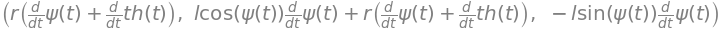

In [6]:
# x_w, x_b, y_bを微分
dx_w = sp.diff(x_w, t)
dx_b = sp.diff(x_b, t)
dy_b = sp.diff(y_b, t)

dx_w, dx_b, dy_b

これを使って運動エネルギー、位置エネルギーを表すと以下のようになります。

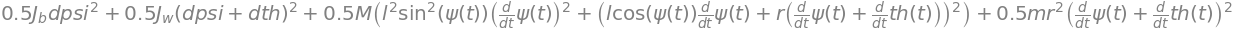

In [7]:
K = 1/2*M*(dx_b**2 + dy_b**2) + 1/2*J_b*dpsi**2 + 1/2*m*dx_w**2 + 1/2*J_w*(dpsi + dth)**2
K

ここで、時間の関数として定義していた$\theta(t), \psi(t)$とその微分を変数$th, psi, dth, dpsi$に置換えます。

In [8]:
K = K.subs({sp.diff(psiF(t), t): dpsi, sp.diff(thF(t), t): dth})
K = K.subs({psiF(t): psi, thF: th})
K

### オイラー・ラグランジュL
オイラー・ラグランジュの$L = K - U$に、幾何的な関係を代入すると以下のようになります。

In [9]:
L = K - U
L.simplify()

### オイラー・ラグランジュの微分
ここで、$\frac{d}{dt}(\frac{\partial L}{\partial \dot{q_i}})$を求めるために、$L_{q_i} = \frac{\partial L}{\partial \dot{q}_i}$として、以下の公式を使います。

$$
\frac{d}{dt} \left (\frac{\partial L}{\partial \dot{q_i}} \right ) = \Sigma_{j = 1}^N\left ( \frac{\partial L_{q_i}}{\partial \dot{q_i}} \ddot{q}_j + \frac{\partial L_{q_i}}{\partial q_j} \dot{q}_j \right)
$$

In [10]:
N = len(q)

In [11]:
dLq = []
ddLq = []
eq = []
for i in range(N):
  dLq.append(sp.diff(L, dq[i]))
  temp = 0
  for j in range(N):
    temp = temp + sp.diff(dLq[i], dq[j])*ddq[j] + sp.diff(dLq[i], q[j])*dq[j]
  ddLq.append(temp)
  eq.append(ddLq[i] - sp.diff(L, q[i]))

In [12]:
for i in range(N):
  eq[i] = eq[i].simplify()

In [13]:
print(eq[0])

-1.0*M*dpsi**2*l*r*sin(psi) + 1.0*ddpsi*(J_w + M*r*(l*cos(psi) + r) + m*r**2) + 1.0*ddth*(J_w + M*r**2 + m*r**2)


In [14]:
print(eq[1])

1.0*J_b*ddpsi + 1.0*J_w*ddpsi + 1.0*J_w*ddth + 1.0*M*ddpsi*l**2 + 2.0*M*ddpsi*l*r*cos(psi) + 1.0*M*ddpsi*r**2 + 1.0*M*ddth*l*r*cos(psi) + 1.0*M*ddth*r**2 - 1.0*M*dpsi**2*l*r*sin(psi) - 1.0*M*g*l*sin(psi) + 1.0*ddpsi*m*r**2 + 1.0*ddth*m*r**2


In [15]:
add_eq = eq[0] + eq[1]
add_eq = add_eq.simplify()

In [16]:
add_eq.subs({sp.cos(psi): 1, sp.sin(psi): psi, dpsi**2: 0, psi*dpsi: 0})

上記の結果を式で表すと以下のようになります。
$$
J_b \ddot{\psi} + 2 J_w \ddot{\psi} + 2 J_w \ddot{\theta} + M l^2 \ddot{\psi} + 3 M l r \ddot{\psi} + 2 M r^2 \ddot{\psi} + M l r \ddot{\theta} + 2 M r^2 \ddot{\theta} - M g l \psi + 2 r^2 \ddot{\psi} + 2 m r^2 \ddot{\theta} 
$$



これを$\ddot{\theta}, \ddot{\psi}$について整理すると求める式(12)が求まります。

$$
( J_b + 2 J_w + M l^2 + 3 M l r + 2 M r^2 + 2 m r^2 )\ddot{\psi}
+ (2 J_w + M l r + 2 M r^2 + 2 m r^2)\ddot{\theta} - M l g \psi = 0
\tag{12}
$$